In [1]:
from next_sparseconvnet.utils.data_loaders import DataGen, LabelType, read_events_info
import tables as tb
from invisible_cities.io.dst_io import load_dst

In [2]:
new_data = '/home/mmkekic/MC_dataset/new_data/train_dataset_5mm_all.h5'
old_data = '/home/mmkekic/MC_dataset/new_data/train_dataset_all.h5'

In [3]:
new_validdata = '/home/mmkekic/MC_dataset/new_data/valid_dataset_5mm.h5'
old_validdata = '/home/mmkekic/MC_dataset/new_data/valid_dataset.h5'

In [4]:
load_dst(new_validdata, 'DATASET', 'EventsInfo')

,event_id,binclass,pathname,basename,dataset_id
0,2000000000,0,/home/gdiaz/data_for_marija/tlde_nn/nexus,nexus_2000_tlde.h5,0
1,2000000001,0,/home/gdiaz/data_for_marija/tlde_nn/nexus,nexus_2000_tlde.h5,1
2,2000000002,0,/home/gdiaz/data_for_marija/tlde_nn/nexus,nexus_2000_tlde.h5,2
3,2000000003,0,/home/gdiaz/data_for_marija/tlde_nn/nexus,nexus_2000_tlde.h5,3
4,2000000004,0,/home/gdiaz/data_for_marija/tlde_nn/nexus,nexus_2000_tlde.h5,4
...,...,...,...,...,...
32267,2099000343,1,/home/gdiaz/data_for_marija/tlde_nn/nexus,nexus_2099_tlde.h5,32267
32268,2099000344,0,/home/gdiaz/data_for_marija/tlde_nn/nexus,nexus_2099_tlde.h5,32268
32269,2099000345,0,/home/gdiaz/data_for_marija/tlde_nn/nexus,nexus_2099_tlde.h5,32269
32270,2099000346,1,/home/gdiaz/data_for_marija/tlde_nn/nexus,nexus_2099_tlde.h5,32270


In [5]:
old = DataGen(old_data, LabelType.Segmentation).bininfo
new = DataGen(new_data, LabelType.Segmentation).bininfo

In [6]:
voxeles = load_dst(old_data, 'DATASET', 'Voxels')

KeyboardInterrupt: 

In [ ]:
voxeles

In [7]:
voxeles5mm = load_dst(new_data, 'DATASET', 'Voxels')

In [ ]:
voxel_valid = load_dst(old_validdata, 'DATASET', 'Voxels')
voxel_valid5mm = load_dst(new_validdata, 'DATASET', 'Voxels')

In [54]:
max(voxeles['xbin']), max(voxeles['ybin']), max(voxeles['zbin'])

(427, 427, 532)

In [59]:
max(voxel_valid['xbin']), max(voxel_valid['ybin']), max(voxel_valid['zbin'])

(427, 427, 532)

In [56]:
max(voxeles5mm['xbin']), max(voxeles5mm['ybin']), max(voxeles5mm['zbin'])

(85, 85, 106)

In [60]:
max(voxel_valid5mm['xbin']), max(voxel_valid5mm['ybin']), max(voxel_valid5mm['zbin'])

(85, 85, 106)

In [31]:
old

,min_x,max_x,nbins_x,min_y,max_y,nbins_y,min_z,max_z,nbins_z,Rmax
0,-220,220,441,-220,220,441,0,550,551,220


In [32]:
new

,min_x,max_x,nbins_x,min_y,max_y,nbins_y,min_z,max_z,nbins_z,Rmax
0,-220,220,89,-220,220,89,0,550,111,220


In [8]:
from next_sparseconvnet.networks.building_blocks import calculate_output_dimension

In [9]:
calculate_output_dimension((149, 149, 149), [9, 7, 5, 3, 3], [2, 2, 2, 2])

[7, 7, 7]

In [10]:
calculate_output_dimension((135, 135, 135), [7, 5, 3, 3], [4, 2, 2])

[7, 7, 7]

# Prueba entreno nueva UNet

In [1]:
import torch
from next_sparseconvnet.utils.data_loaders import LabelType
from next_sparseconvnet.networks.architectures import NetArchitecture, UNet
from next_sparseconvnet.utils.train_utils import train_segmentation

In [45]:
labeltype  = LabelType.Segmentation
netarch    = NetArchitecture.UNet

#Train params
nepoch = 10
train_file = '/home/mmkekic/MC_dataset/new_data/train_dataset_5mm_all.h5'
valid_file = '/home/mmkekic/MC_dataset/new_data/valid_dataset_5mm.h5'
train_batch = 100
valid_batch = 20
checkpoint_dir = '/home/mperez/NEXT_SPARSECONVNET/examples/checkpoint_example'
tensorboard_dir = '/home/mperez/NEXT_SPARSECONVNET/examples/tensorboard_example'
num_workers = 3
nevents_train = 2000
nevents_valid = 500
saved_weights = None
weight_loss = [0.3576, 0.0357, 0.6067]
augmentation = False
# weight_loss = True calculates weights from first 5000 events;
# weight_loss = None uses loss without weights

#UNet params
spatial_size      = (135, 135, 135)
init_conv_nplanes = 8
init_conv_kernel  = 7
kernel_sizes      = [7, 5, 3, 3]
stride_sizes      = [4, 2, 2]
basic_num         = 2
momentum          = 0.7

#Optimizer parameters
lr = 1e-2
betas = (0.9, 0.999)
eps = 1e-6
weight_decay = 0


In [46]:
net = UNet(spatial_size,
           init_conv_nplanes,
           init_conv_kernel,
           kernel_sizes,
           stride_sizes,
           basic_num,
           momentum = momentum)
net = net.cuda()
criterion = torch.nn.CrossEntropyLoss(weight = torch.Tensor(weight_loss).cuda())
optimizer = torch.optim.Adam(net.parameters(),
                           lr = lr,
                           betas = betas,
                           eps = eps,
                           weight_decay = weight_decay)
train_segmentation(nepoch = nepoch,
                           train_data_path = train_file,
                           valid_data_path = valid_file,
                           train_batch_size = train_batch,
                           valid_batch_size = valid_batch,
                           net = net,
                           criterion = criterion,
                           optimizer = optimizer,
                           checkpoint_dir = checkpoint_dir,
                           tensorboard_dir = tensorboard_dir,
                           num_workers = num_workers,
                           nevents_train = nevents_train,
                           nevents_valid = nevents_valid,
                           augmentation  = augmentation)

Train Epoch: 0	 Loss: 1.123218
	 Validation Loss: 1.009455
Train Epoch: 1	 Loss: 0.840644
	 Validation Loss: 0.855320
Train Epoch: 2	 Loss: 0.692777
	 Validation Loss: 0.910861
Train Epoch: 3	 Loss: 0.533643
	 Validation Loss: 1.061239
Train Epoch: 4	 Loss: 0.394407
	 Validation Loss: 1.207055
Train Epoch: 5	 Loss: 0.265427
	 Validation Loss: 1.456430
Train Epoch: 6	 Loss: 0.187286
	 Validation Loss: 1.616539
Train Epoch: 7	 Loss: 0.150098
	 Validation Loss: 2.040583
Train Epoch: 8	 Loss: 0.110802
	 Validation Loss: 2.177264
Train Epoch: 9	 Loss: 0.085342
	 Validation Loss: 2.419653


# Load dst function etc



In [73]:
def read_events_info(filename, nevents):
    events = load_dst(filename, 'DATASET', 'EventsInfo')
    if nevents is not None:
        if nevents>=len(events):
            warnings.warn(UserWarning(f'length of dataset smaller than {nevents}, using full dataset'))
        else:
            events = events.iloc[:nevents]
    return events

# Plotting results


In [8]:
import numpy as np
import pandas as pd
import tables as tb
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib         as mpl
import matplotlib.pyplot  as plt
import itertools
from mpl_toolkits.mplot3d import Axes3D
from invisible_cities.io import mcinfo_io as mio
from invisible_cities.io   .dst_io  import load_dst
from scipy import stats
from next_sparseconvnet.data_io_scripts.plotting_utils import plot_projections, plot_3d_vox, plot_3d_hits
from next_sparseconvnet.utils.data_loaders import read_event
from next_sparseconvnet.utils.blob_classification_utils import number_of_blobs, segmentation_blob_classification, success_rates

from invisible_cities.io import mcinfo_io as mio
from next_sparseconvnet.utils.data_loaders             import DataGen, LabelType, read_event
from invisible_cities.io   .dst_io  import load_dst

In [11]:
#for voxel plotting extract the main path volume only
#fixed so that events that dont have track label dont become empty
def get_path_volume(df, label):
    class_1_bool = df[label]==1
    if any(class_1_bool):
        dfp = df[class_1_bool][['xbin', 'ybin', 'zbin']]
        xmin, xmax = dfp.xbin.min(), dfp.xbin.max()
        ymin, ymax = dfp.ybin.min(), dfp.ybin.max()
        zmin, zmax = dfp.zbin.min(), dfp.zbin.max()
        volum = df.xbin.between(xmin-5, xmax+5) & df.ybin.between(ymin-5, ymax+5) & df.zbin.between(zmin-5, zmax+5)
        return df[volum]
    else:
        return df

In [4]:
#THIS IS AN EDITED FUNCTION to know also the blobs for the valid dataset (which have no threshols, voxels are just labelled)
#i use this just in case i want to see if number_of_blobs works correctly bc it may happen that it predicts a number of blobs
#that doesn't correspond to what the data is!! (i mean, imagine my function predicts 2 blobs but the event is labeled as bkg, that would be just... bad)
def number_of_blobs(dataset_path, dataset_id, threshold, class_type = 'class_2', max_distance = np.sqrt(3)):
    '''
    For a prediction, returns the number of blobs for data above a threshold using graphs
    '''
    if threshold == False:
        event_df = read_event(dataset_path, dataset_id)
        selected_hits = pd.DataFrame()
        selected_hits[['xbin', 'ybin', 'zbin']] = event_df[['xbin', 'ybin', 'zbin']][event_df['segclass'] == 2]
    else:
        event_df = read_event(dataset_path, dataset_id, table='VoxelsPred')
        selected_hits = pd.DataFrame()
        selected_hits[['xbin', 'ybin', 'zbin']] = event_df[['xbin', 'ybin', 'zbin']][event_df[class_type]>threshold]
        
    voxels = [tuple(x) for x in selected_hits.to_numpy()]
    vox_graph = nx.Graph()
    vox_graph.add_nodes_from(voxels)
    for va, vb in itertools.combinations(voxels, 2):
        va_arr, vb_arr = np.array(va), np.array(vb)
        dis = np.linalg.norm(va_arr-vb_arr)
        if dis < max_distance:
            vox_graph.add_edge(va, vb, distance = dis)
    nblobs = nx.algorithms.components.number_connected_components(vox_graph)
    return nblobs

In [10]:
#edited function to write some things on the graphs
def plot_3d_vox(hits_digitized, type_of_event, evnum,  value='energy', coords = ['x', 'y', 'z'], th=0, edgecolor=None, cmap=mpl.cm.jet, size = 1):

    xmin, xmax = hits_digitized[coords[0]].min(), hits_digitized[coords[0]].max()
    ymin, ymax = hits_digitized[coords[1]].min(), hits_digitized[coords[1]].max()
    zmin, zmax = hits_digitized[coords[2]].min(), hits_digitized[coords[2]].max()

    nbinsX = int(np.ceil((xmax-xmin))) + 2
    nbinsY = int(np.ceil((ymax-ymin))) + 2
    nbinsZ = int(np.ceil((zmax-zmin))) + 2
    xarr = np.ones(shape=(nbinsX, nbinsY, nbinsZ))*th

    nonzeros = np.vstack([hits_digitized[coords[0]].values-xmin+1,
                          hits_digitized[coords[1]].values-ymin+1,
                          hits_digitized[coords[2]].values-zmin+1])
    xarr[tuple(nonzeros)] = hits_digitized[value].values
    dim     = xarr.shape
    voxels  = xarr > th

    fig  = plt.figure(figsize=(15, 15), frameon=False)
    gs   = fig.add_gridspec(2, 40)
    ax   = fig.add_subplot(gs[0, 0:16], projection = '3d')
    axcb = fig.add_subplot(gs[0, 18])
    norm = mpl.colors.Normalize(vmin=xarr.min(), vmax=xarr.max() + 1)#mpl.colors.Normalize(vmin=-1, vmax=1)
    m    = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    
    #ax.view_init(None, -80)
    
    if size == 5:
        #no se como hacerlo de otra forma........ (que se vea siempre más claro etc...)
        ax.set_xticks(np.arange(0, (nbinsX + 1), 2))
        ax.set_xticklabels(np.arange(0, (nbinsX + 1) * size, size * 2))
        ax.set_yticks(np.arange(0, (nbinsY + 1), 2))
        ax.set_yticklabels(np.arange(0, (nbinsY + 1) * size, size * 2))
        ax.set_zticks(np.arange(0, (nbinsZ + 1), 2))
        ax.set_zticklabels(np.arange(0, (nbinsZ + 1) * size, size * 2))
    
    colors = np.asarray(np.vectorize(m.to_rgba)(xarr))
    colors = np.rollaxis(colors, 0, 4)

    ax.voxels(voxels, facecolors=colors, edgecolor=edgecolor)
    cb = mpl.colorbar.ColorbarBase(axcb, cmap=cmap, norm=norm, orientation='vertical')

    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_zlabel('Z (mm)')
    #ax.set_title(type_of_event + ' - Event {}'.format(evnum)) LE QUITE PARA HACER UNA COSITE
    if value == 'energy':
        cb.set_label('E (MeV)')
    elif value == 'segclass':
        cb.set_label('Label')
    elif value == 'pred':
        cb.set_label('Prediction')
    else:
        cb.set_label (value)
    
    #plt.show()

In [12]:
original_dataset = '/home/mmkekic/MC_dataset/new_data/valid_dataset_5mm.h5'
prediction_dataset = '/home/mperez/DNN_training/predictions/5mm/architecture_2/pred_file8_5mm_2.h5'
pred_dataset_fl = '/home/mperez/DNN_training/predictions/5mm/architecture_2/focal_loss/pred_file11_5mm_fl.h5'

In [128]:
for dataset_id in range(500):    
    nb_orig = number_of_blobs(original_dataset, dataset_id, False)
    nb = number_of_blobs(prediction_dataset, dataset_id, th, class_type = 'class_2', max_distance = np.sqrt(3)) #para 5mm es 5*raiz(3)?
    nb_fl = number_of_blobs(pred_dataset_fl, dataset_id, 0.45, class_type = 'class_2', max_distance = np.sqrt(3))
    if nb_orig == 1 and nb ==2:
        print('bkg, pred as signal', dataset_id)
    elif nb_orig == 1 and nb_fl ==2:
        print('bkg, pred as signal', dataset_id)
    elif nb_orig == 2 and nb != 2:
        print('signal pred as bkg', dataset_id)
    elif nb_orig == 2 and nb_fl != 2:
        print('signal pred as bkg', dataset_id)

signal pred as bkg 5
bkg, pred as signal 10
bkg, pred as signal 29
bkg, pred as signal 35
signal pred as bkg 41
bkg, pred as signal 106
bkg, pred as signal 113
bkg, pred as signal 114
signal pred as bkg 119
bkg, pred as signal 123
signal pred as bkg 126
bkg, pred as signal 133
signal pred as bkg 152
signal pred as bkg 176
bkg, pred as signal 184
bkg, pred as signal 186
bkg, pred as signal 208
signal pred as bkg 218
bkg, pred as signal 240
bkg, pred as signal 251
bkg, pred as signal 268
bkg, pred as signal 270
bkg, pred as signal 287
signal pred as bkg 295
bkg, pred as signal 310
bkg, pred as signal 337
bkg, pred as signal 346
signal pred as bkg 347
bkg, pred as signal 372
bkg, pred as signal 375
bkg, pred as signal 380
bkg, pred as signal 381
signal pred as bkg 408
signal pred as bkg 422
signal pred as bkg 425
signal pred as bkg 439
signal pred as bkg 441
bkg, pred as signal 450
bkg, pred as signal 451
bkg, pred as signal 455
bkg, pred as signal 456
bkg, pred as signal 460


In [218]:
for dataset_id in range(5000):
    original_event = read_event(original_dataset, dataset_id, table='Voxels') 
    org_shrinked = get_path_volume(original_event, label='segclass')

    predicted_event = read_event(prediction_dataset, dataset_id, table='VoxelsPred') 
    predicted_event = predicted_event.assign(pred = np.argmax(predicted_event[['class_0', 'class_1', 'class_2']].values, axis=-1))
    
    nb_orig = number_of_blobs(original_dataset, dataset_id, False)
    nb1 = number_of_blobs(prediction_dataset, dataset_id, 0.4, class_type = 'class_2', max_distance = np.sqrt(3))
    nb2 = number_of_blobs(prediction_dataset, dataset_id, 0.65, class_type = 'class_2', max_distance = np.sqrt(3))
    nb3 = number_of_blobs(prediction_dataset, dataset_id, 0.8, class_type = 'class_2', max_distance = np.sqrt(3))
    if nb2 == nb1 and nb2 == nb3 and nb2 > 2 and nb_orig == 2:
        print('este queremos', dataset_id)

este queremos 3781
este queremos 4060


In [14]:
def blobmask(pred_df, th):
    mask = pred_df['class_2']>th
    clas = [int(mask[i]) for i in range(len(mask))]
    pred_df = pred_df.assign(blob = clas)
    return pred_df

In [15]:
dataset_id = 10#np.random.randint(32000) #int(failed_predictions[2])
print(dataset_id)

original_event = read_event(original_dataset, dataset_id, table='Voxels') 
org_shrinked = get_path_volume(original_event, label='segclass')

predicted_event = read_event(prediction_dataset, dataset_id, table='VoxelsPred') 
predicted_event = predicted_event.assign(pred = np.argmax(predicted_event[['class_0', 'class_1', 'class_2']].values, axis=-1))

predicted_event1 = blobmask(predicted_event, 0.4)
pred_shrinked1 = get_path_volume(predicted_event1, label='pred')

predicted_event2 = blobmask(predicted_event, 0.65)
pred_shrinked2 = get_path_volume(predicted_event2, label='pred')

predicted_event3 = blobmask(predicted_event, 0.8)
pred_shrinked3 = get_path_volume(predicted_event3, label='pred')

pred_fl = read_event(pred_dataset_fl, dataset_id, table='VoxelsPred') 
pred_fl = pred_fl.assign(pred = np.argmax(pred_fl[['class_0', 'class_1', 'class_2']].values, axis=-1))
pred_sh_fl = get_path_volume(pred_fl, label='pred')

10


El evento 1396 presenta un solo voxel de clase 2 en el dataset original, por tanto tiene solo 1 blob (mi funcion lo calcula bien) y por tanto es BKG, pero el mismo evento tiene como 'binclass' asignado 1 que significa SEÑAL, no bkg....

El evento 3198 presenta 2 blobs a la vista y mi funcion calcula 2 blobs tb, pero estan separados simplemente por un 'other particle' entonces entiendo q es como un blob solo en verdad... el evento original de hecho está clasificado como si tuviera solo 1 blob, rollo como bkg... y luego la prediccion pues tiene como un blob pero en algun momento supongo que se desconecta porque mi funcion calcula que tiene 2 y que es señal, por eso sale en los failed pred

El evento 3362 es

In [221]:
nb_orig = number_of_blobs(original_dataset, dataset_id, False)
nb1 = number_of_blobs(prediction_dataset, dataset_id, 0.4, class_type = 'class_2', max_distance = np.sqrt(3)) #para 5mm es 5*raiz(3)?
nb2 = number_of_blobs(prediction_dataset, dataset_id, 0.65, class_type = 'class_2', max_distance = np.sqrt(3))
nb3 = number_of_blobs(prediction_dataset, dataset_id, 0.8, class_type = 'class_2', max_distance = np.sqrt(3))

print(nb_orig, nb1, nb2, nb3)

2 3 3 3


No entiendo pq en el evento 48 si pongo threshold 0.65 (que es con el que busqué las predicciones fallidas) me da mal, ya que obtengo 3 blobs para el original y 1 para el predecido, y eso clasificaría siempre como bkg!!! tendría que clasificar uno como 2 blobs para que apareciera en esta lista, pero con ese threshold me parece imposible, algo falla...

Vale segun lo q veo la prediccion me la marcó como bkg o sea que si que coincide con lo de threshold de 0.65 PERO la original pone que es SEÑAL (en plan en los datos directamente, ahi yo no hice nas) cuando tambien claramente hay 3 blobs o sea este dato simplemente tiene que ser defectuoso o algo no?

In [16]:
df = load_dst(original_dataset, 'DATASET', 'EventsInfo')
df.loc[114]

event_id                                     2000000114
binclass                                              0
pathname      /home/gdiaz/data_for_marija/tlde_nn/nexus
basename                             nexus_2000_tlde.h5
dataset_id                                          114
Name: 114, dtype: object

In [17]:
#df_particles = mio.load_mcparticles_df('/home/gdiaz/data_for_marija/tlde_nn/nexus/nexus_2001_tlde.h5')
df_hits = mio.load_mchits_df('/home/gdiaz/data_for_marija/tlde_nn/nexus/nexus_2000_tlde.h5')

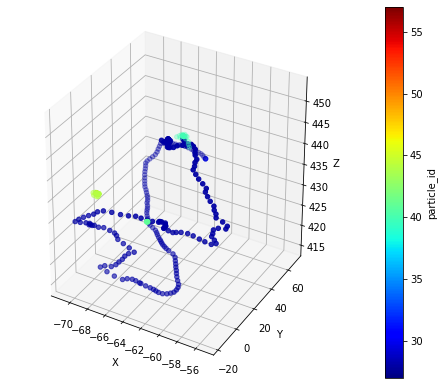

In [18]:
plot_3d_hits((df_hits.loc[2000000114]).reset_index(), value = 'particle_id')

In [33]:
org_shrinked

,xbin,ybin,zbin,energy,segclass,binclass,dataset_id
0,57,63,43,0.007521,1,0,10
1,52,60,43,0.045865,1,0,10
2,54,61,42,0.019391,1,0,10
3,50,61,43,0.015694,1,0,10
4,48,62,44,0.044094,0,0,10
5,48,63,44,0.164693,0,0,10
6,57,67,43,0.058804,1,0,10
7,57,63,44,0.003659,1,0,10
8,50,60,43,0.010766,1,0,10
9,57,64,44,0.028121,1,0,10


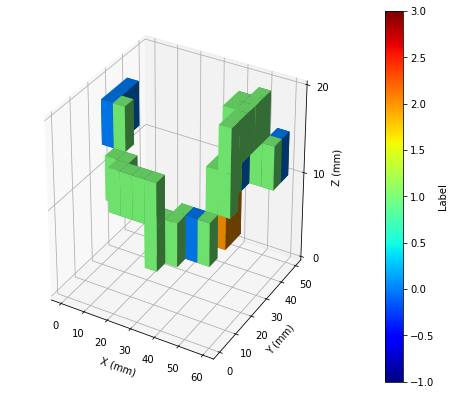

In [19]:
plot_3d_vox(org_shrinked, 'Original', dataset_id, value='segclass', coords = ['xbin', 'ybin', 'zbin'], th=-1, size = 5)
#plt.suptitle('Original - Event {}'.format(dataset_id))
#plt.title('nblobs: {}'.format(nb_orig))
plt.show()

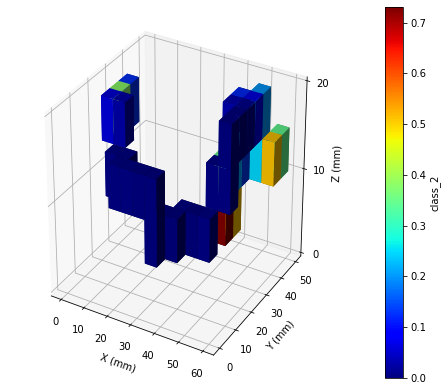

In [16]:
plot_3d_vox(pred_shrinked1, 'Prediction', dataset_id, value='class_2', coords = ['xbin', 'ybin', 'zbin'], th=0, size = 5)
#plt.title('nblobs: {}'.format(nb))
plt.show()

In [19]:
from matplotlib import colors


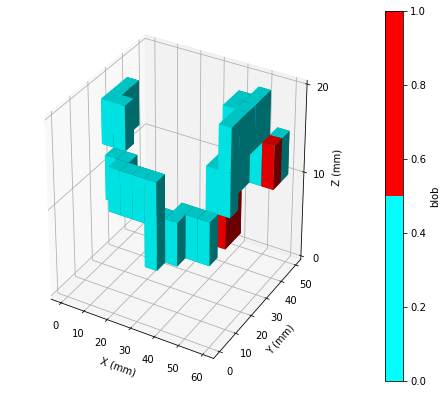

In [23]:
plot_3d_vox(pred_shrinked1, 'Prediction', dataset_id, value='blob', coords = ['xbin', 'ybin', 'zbin'], th=-0.001, size = 5, cmap=colors.ListedColormap(['cyan', 'red']))
#plt.title('nblobs: {}'.format(nb))
plt.show()

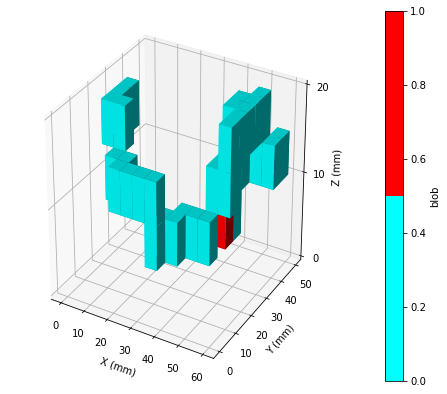

In [24]:
plot_3d_vox(pred_shrinked2, 'Prediction', dataset_id, value='blob', coords = ['xbin', 'ybin', 'zbin'], th=-0.001, size = 5, cmap=colors.ListedColormap(['cyan', 'red']))
#plt.title('nblobs: {}'.format(nb))
plt.show()

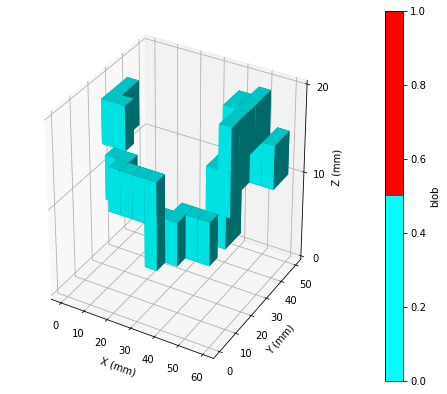

In [30]:
plot_3d_vox(pred_shrinked3, 'Prediction', dataset_id, value='blob', coords = ['xbin', 'ybin', 'zbin'], th=-0.001, size = 5, cmap=colors.ListedColormap(['cyan', 'red']))
#plt.title('nblobs: {}'.format(nb))
plt.show()

In [12]:
from next_sparseconvnet.utils.blob_classification_utils import number_of_blobs, segmentation_blob_classification, success_rates
from next_sparseconvnet.utils.data_loaders import read_event
import tables as tb
import numpy as np

Con el mejor threshold (visto abajo) voy a mirar q pasa con los que fallan, si se repite mucho algun patron en ellos etc...

In [33]:
threshold = np.arange(0.05, 1, 0.05)
roc_curve = []
print('th acc tpr tnr')
for th in threshold:
    classified_df = segmentation_blob_classification(original_dataset, pred_dataset_fl, th) #there are 32272 events in total
    acc, tpr, tnr = success_rates(classified_df['binclass'], classified_df['pred_class'])
    roc_curve.append([tpr, tnr])
    print(th, acc, tpr, tnr)
roc_curve = np.array(roc_curve)

th acc tpr tnr
0.05 0.7514563708477937 0.7731731511076821 0.7429630587525324
0.1 0.8177367377293009 0.849333186377163 0.8053795422216474
0.15000000000000002 0.8430218145761031 0.8636614129835777 0.8349497823182034
0.2 0.8590109072880515 0.8720379146919431 0.8539161170740118
0.25 0.872583044124938 0.8787611594841839 0.8701668175352386
0.3 0.8854115022310362 0.8812961534222418 0.8870209922841502
0.35000000000000003 0.8994794248884482 0.8882398324699659 0.9038751670330618
0.4 0.9137642538423401 0.8917667805576986 0.9223673434199751
0.45 0.9235870104115023 0.8873580954480326 0.9377559377559378
0.5 0.9287927615270203 0.8698335721371101 0.9518513729040045
0.55 0.923029251363411 0.8199052132701422 0.9633604896762792
0.6000000000000001 0.9063274665344571 0.7406590984238951 0.9711194448036553
0.6500000000000001 0.8835832920178482 0.6383776038796429 0.9794818742187164
0.7000000000000001 0.8552615270203272 0.5218780998567177 0.9856459330143541


KeyboardInterrupt: 

Okay the accuracy peaks usually for 0.65 of threshold BUT the ¿roc? curve has its best point near but maybe not at .65?

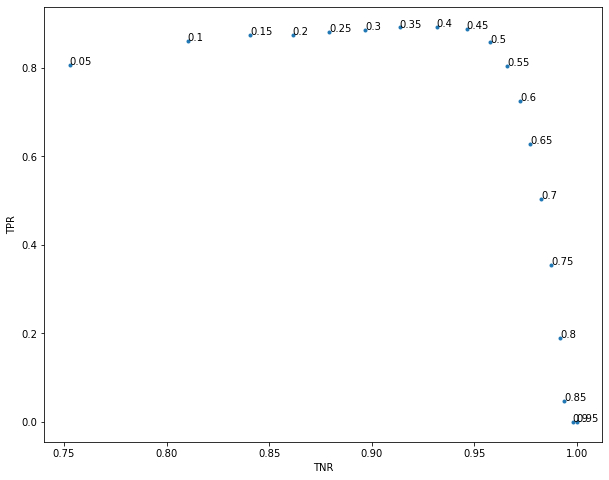

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 8))
plt.plot(roc_curve[:, 1], roc_curve[:, 0], '.')
plt.xlabel('TNR')
plt.ylabel('TPR')
for i, n in enumerate(threshold):
    plt.annotate(round(n, 2), (roc_curve[i, 1], roc_curve[i, 0]))
#plt.xlim([0, 1])
#plt.ylim([0, 1])
plt.show()

# Hits and voxels 

In [55]:
def plot_3d_hits(hits, value='energy', coords = ['x', 'y', 'z'], cmap = mpl.cm.jet):
    fig  = plt.figure(figsize=(15, 15), frameon=False)
    gs   = fig.add_gridspec(2, 40)
    ax   = fig.add_subplot(gs[0, 0:16], projection = '3d')
    axcb = fig.add_subplot(gs[0, 18])
    norm = mpl.colors.Normalize(vmin=hits.loc[:, value].min(), vmax=hits.loc[:, value].max())

    m    = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

    colors = np.asarray(np.vectorize(m.to_rgba)(hits.loc[:, value]))
    colors = np.rollaxis(colors, 0, 2)

    ax.scatter(hits[coords[0]], hits[coords[1]], hits[coords[2]], c=colors, marker='o')
    cb = mpl.colorbar.ColorbarBase(axcb, cmap=cmap, norm=norm, orientation='vertical')


    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_zlabel('Z (mm)')
    if value == 'energy':
        cb.set_label ('E (MeV)')
    elif value == 'particle_id':
        cb.set_label('Particle ID')
    else:
        cb.set_label (value)
    plt.show()

In [12]:
original_dataset_5mm = '/home/mmkekic/MC_dataset/new_data/valid_dataset_5mm.h5'
original_dataset_1mm = '/home/mmkekic/MC_dataset/new_data/valid_dataset.h5'
save_path = '/home/mperez/DNN_training/images/voxelize/'

In [8]:
df = load_dst(original_dataset_5mm, 'DATASET', 'EventsInfo')

In [9]:
part_id = 2180

In [10]:
df.loc[part_id]

event_id                                     2006000282
binclass                                              1
pathname      /home/gdiaz/data_for_marija/tlde_nn/nexus
basename                             nexus_2006_tlde.h5
dataset_id                                         2180
Name: 2180, dtype: object

In [11]:
df_hits = mio.load_mchits_df('/home/gdiaz/data_for_marija/tlde_nn/nexus/nexus_2006_tlde.h5')

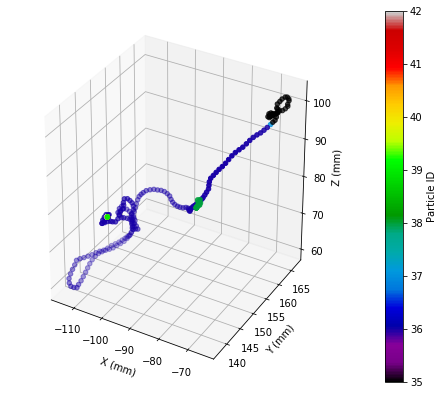

In [56]:
plot_3d_hits((df_hits.loc[df.loc[part_id].event_id]).reset_index(), value = 'particle_id', cmap = mpl.cm.nipy_spectral)
#plt.savefig(save_path + 'en_hits.png')

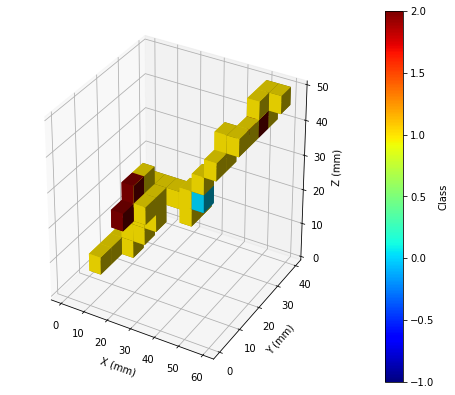

In [50]:
ev = read_event(original_dataset_5mm, part_id, table='Voxels') 
ev_shr = get_path_volume(ev, label='segclass')
plot_3d_vox(ev_shr, 'Original', part_id, value = 'segclass', coords = ['xbin', 'ybin', 'zbin'], th=-1, size = 5)
#plt.savefig(save_path + 'en_5mm.png')

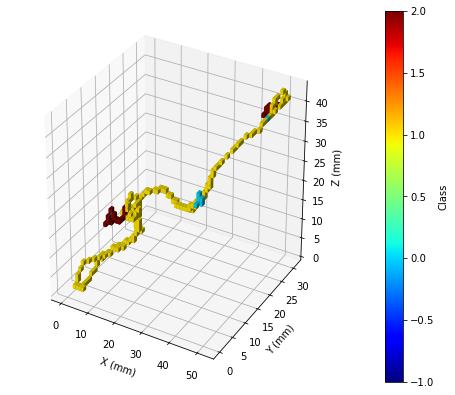

In [34]:
ev = read_event(original_dataset_1mm, part_id, table='Voxels') 
ev_shr = get_path_volume(ev, label='segclass')
plot_3d_vox(ev_shr, 'Original', part_id, value = 'segclass', coords = ['xbin', 'ybin', 'zbin'], th=-1) #usaba cmap rainbow
#plt.savefig(save_path + 'en_1mm.png')

Preguntar a marija como hace el label de los voxeles rollo... si en un voxel hay hits de track y de otra particula, como etiquetas ese voxel?? por lo que tiene mas energía o por lo que hya más tipos o como?

Creo q simplemente si está fuera de la traza se clasifica como other particle y si está dentro anke sea other particle se clasifica como traza x estar muy cerca!!

Accent


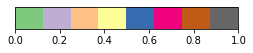

Accent_r


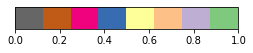

Blues


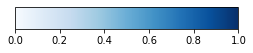

Blues_r


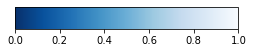

BrBG


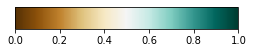

BrBG_r


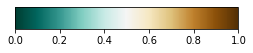

BuGn


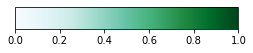

BuGn_r


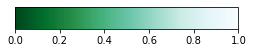

BuPu


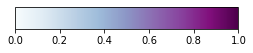

BuPu_r


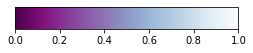

CMRmap


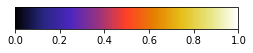

CMRmap_r


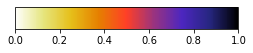

Dark2


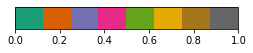

Dark2_r


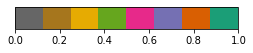

GnBu


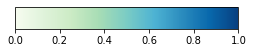

GnBu_r


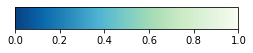

Greens


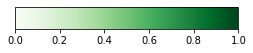

Greens_r


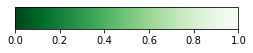

Greys


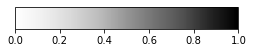

Greys_r


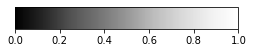

OrRd


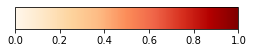

OrRd_r


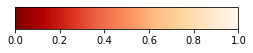

Oranges


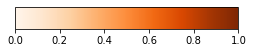

Oranges_r


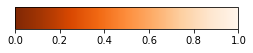

PRGn


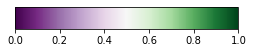

PRGn_r


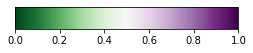

Paired


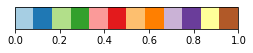

Paired_r


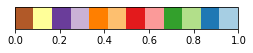

Pastel1


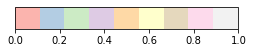

Pastel1_r


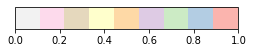

Pastel2


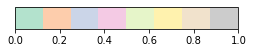

Pastel2_r


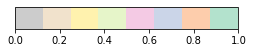

PiYG


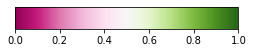

PiYG_r


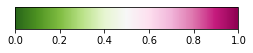

PuBu


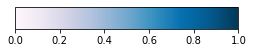

PuBuGn


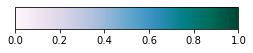

PuBuGn_r


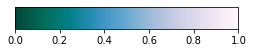

PuBu_r


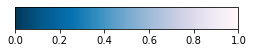

PuOr


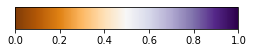

PuOr_r


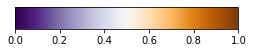

PuRd


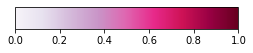

PuRd_r


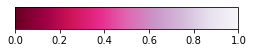

Purples


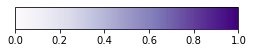

Purples_r


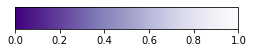

RdBu


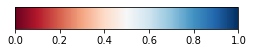

RdBu_r


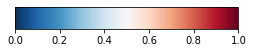

RdGy


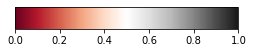

RdGy_r


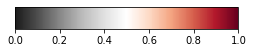

RdPu


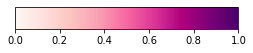

RdPu_r


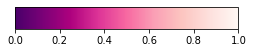

RdYlBu


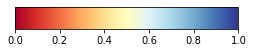

RdYlBu_r


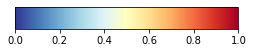

RdYlGn


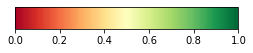

RdYlGn_r


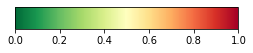

Reds


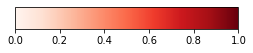

Reds_r


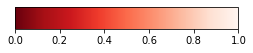

Set1


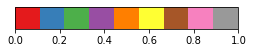

Set1_r


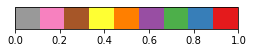

Set2


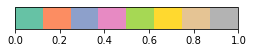

Set2_r


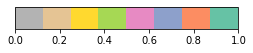

Set3


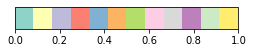

Set3_r


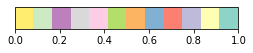

Spectral


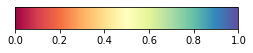

Spectral_r


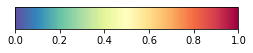

Wistia


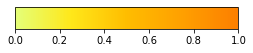

Wistia_r


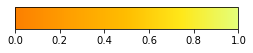

YlGn


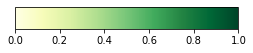

YlGnBu


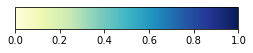

YlGnBu_r


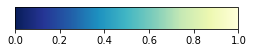

YlGn_r


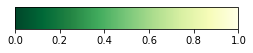

YlOrBr


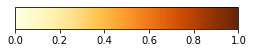

YlOrBr_r


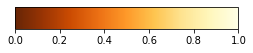

YlOrRd


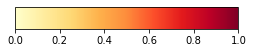

YlOrRd_r


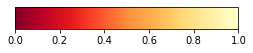

afmhot


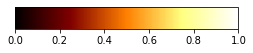

afmhot_r


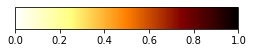

autumn


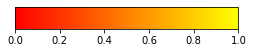

autumn_r


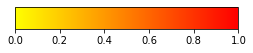

binary


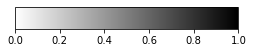

binary_r


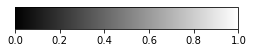

bone


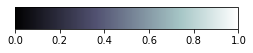

bone_r


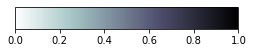

brg


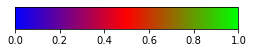

brg_r


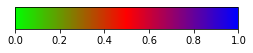

bwr


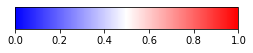

bwr_r


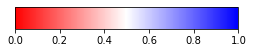

cividis


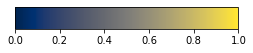

cividis_r


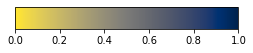

cool


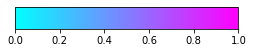

cool_r


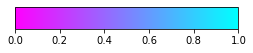

coolwarm


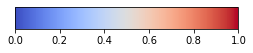

coolwarm_r


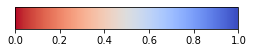

copper


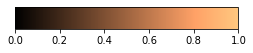

copper_r


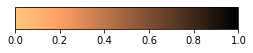

cubehelix


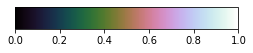

cubehelix_r


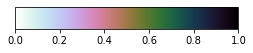

flag


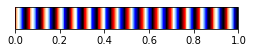

flag_r


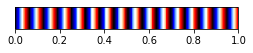

gist_earth


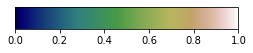

gist_earth_r


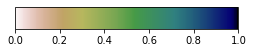

gist_gray


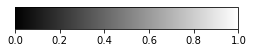

gist_gray_r


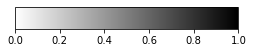

gist_heat


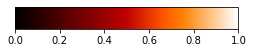

gist_heat_r


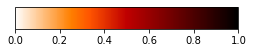

gist_ncar


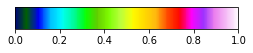

gist_ncar_r


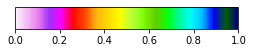

gist_rainbow


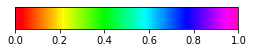

gist_rainbow_r


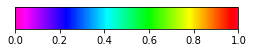

gist_stern


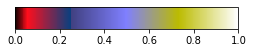

gist_stern_r


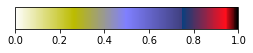

gist_yarg


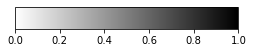

gist_yarg_r


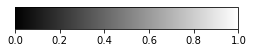

gnuplot


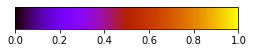

gnuplot2


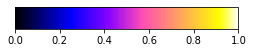

gnuplot2_r


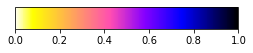

gnuplot_r


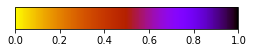

gray


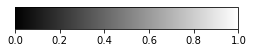

gray_r


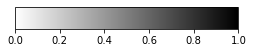

hot


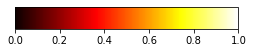

hot_r


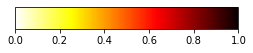

hsv


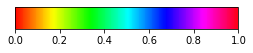

hsv_r


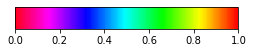

inferno


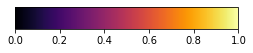

inferno_r


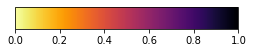

jet


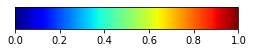

jet_r


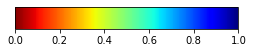

magma


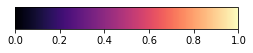

magma_r


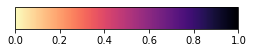

nipy_spectral


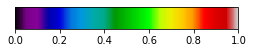

nipy_spectral_r


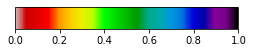

ocean


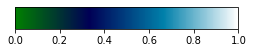

ocean_r


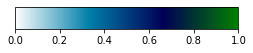

pink


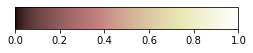

pink_r


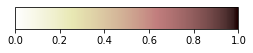

plasma


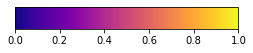

plasma_r


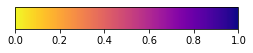

prism


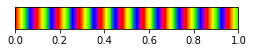

prism_r


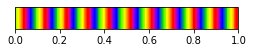

rainbow


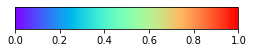

rainbow_r


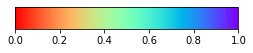

seismic


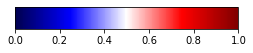

seismic_r


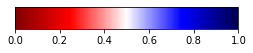

spring


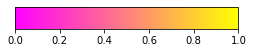

spring_r


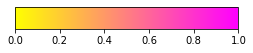

summer


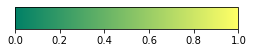

summer_r


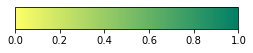

tab10


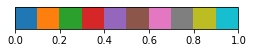

tab10_r


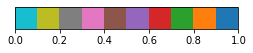

tab20


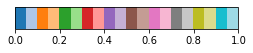

tab20_r


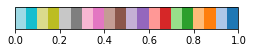

tab20b


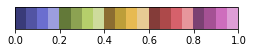

tab20b_r


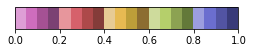

tab20c


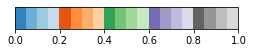

tab20c_r


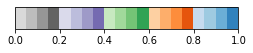

terrain


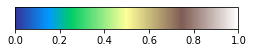

terrain_r


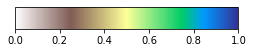

twilight


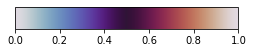

twilight_r


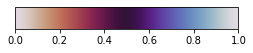

twilight_shifted


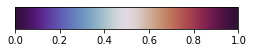

twilight_shifted_r


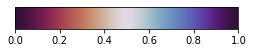

viridis


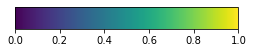

viridis_r


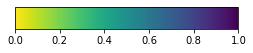

winter


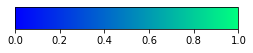

winter_r


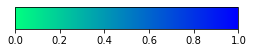

In [42]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_colorMaps(cmap):

    fig, ax = plt.subplots(figsize=(4,0.4))
    col_map = plt.get_cmap(cmap)
    mpl.colorbar.ColorbarBase(ax, cmap=col_map, orientation = 'horizontal')

    plt.show()

for cmap_id in plt.colormaps():
    print(cmap_id)
    plot_colorMaps(cmap_id)